In [119]:
import torch
import torch.nn as nn

import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import torchvision.models as models
from PIL import Image
import cv2
import os
#import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import time
import progressbar   # used to show progressbar during training 
widgets=[
    ' [', progressbar.Timer(), '] ',
    progressbar.Bar(),
    ' (', progressbar.ETA(), ') ',
]

from helper_train import train_model
from helper_evaluation import compute_confusion_matrix
from helper_plotting import plot_training_loss, plot_accuracy, show_examples, plot_confusion_matrix
from helper_dataset import  UnNormalize

In [135]:
##########################
### SETTINGS
##########################

#RANDOM_SEED = 123
batch_size=32
NUM_EPOCHS = 10
lr_rate=0.01
num_epochs=NUM_EPOCHS
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# DEVICE = torch.device('cpu')
device = DEVICE
train_data_path = r"./data/train/"
test_data_path = r"./data/test/"
valid_data_path = r"./data/valid/"

In [136]:
train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(0.5),
    transforms.Normalize((0.5228, 0.5233, 0.5233), (0.2314, 0.2314, 0.2314)),
])

test_transforms = transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize(size=(224,224)),
    torchvision.transforms.RandomHorizontalFlip(0.5),
    torchvision.transforms.Normalize([0.5228, 0.5233, 0.5233], [0.2314, 0.2314, 0.2314])
])
valid_transforms = transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize(size=(224,224)),
    torchvision.transforms.RandomHorizontalFlip(0.5),
    torchvision.transforms.Normalize([0.5228, 0.5233, 0.5233], [0.2314, 0.2314, 0.2314]),
])

In [137]:
train_data = torchvision.datasets.ImageFolder(root=train_data_path,transform=train_transforms)
test_data = torchvision.datasets.ImageFolder(root=test_data_path,transform=test_transforms)
valid_data = torchvision.datasets.ImageFolder(root=valid_data_path,transform=valid_transforms)


train_data_loader = torch.utils.data.DataLoader(dataset=train_data, shuffle=True, batch_size= batch_size,num_workers=2)
test_data_loader  = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size)
valid_data_loader  = torch.utils.data.DataLoader(dataset=valid_data, shuffle=True, batch_size=batch_size, num_workers=2)

In [138]:
classes = ('PNEUMONIA', 'NORMAL', 'COVID19')

for images, labels in train_data_loader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    break

Image batch dimensions: torch.Size([32, 3, 224, 224])
Image label dimensions: torch.Size([32])
Class labels of 10 examples: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 1])


In [139]:
print("Train set:\n---------------------------------------------------")
PNEUMONIA_TRAIN = len(os.listdir(os.path.join(train_data_path, 'PNEUMONIA')))
NORMAL_TRAIN= len(os.listdir(os.path.join(train_data_path, 'NORMAL')))
COVID19_TRAIN= len(os.listdir(os.path.join(train_data_path, 'COVID19')))
print(f"PNEUMONIA_TRAIN={PNEUMONIA_TRAIN}",f"\nNORMAL_TRAIN={NORMAL_TRAIN}",f"\nCOVID19_TRAIN={COVID19_TRAIN}")
Nu_TrainImages=PNEUMONIA_TRAIN+NORMAL_TRAIN+COVID19_TRAIN
print('Total number of train dataset images is ', Nu_TrainImages)
print("\nTest set:\n----------------------------------------------------")
PNEUMONIA_TEST = len(os.listdir(os.path.join(test_data_path, 'PNEUMONIA')))
NORMAL_TEST= len(os.listdir(os.path.join(test_data_path, 'NORMAL')))
COVID19_TEST= len(os.listdir(os.path.join(test_data_path, 'COVID19')))
print(f"PNEUMONIA_TEST={PNEUMONIA_TEST}",f"\nNORMAL_TEST={NORMAL_TEST}",f"\nCOVID19_TEST={COVID19_TEST}")
Nu_TestImages=PNEUMONIA_TEST+NORMAL_TEST+COVID19_TEST
print('Total number of test dataset images is ', Nu_TestImages)
print("\nValid set:\n----------------------------------------------------")
PNEUMONIA_VALID = len(os.listdir(os.path.join(valid_data_path, 'PNEUMONIA')))
NORMAL_VALID= len(os.listdir(os.path.join(valid_data_path, 'NORMAL')))
COVID19_VALID= len(os.listdir(os.path.join(valid_data_path, 'COVID19')))
print(f"PNEUMONIA_TEST={PNEUMONIA_VALID}",f"\nNORMAL_TEST={NORMAL_VALID}",f"\nCOVID19_TEST={COVID19_VALID}")
Nu_ValidImages=PNEUMONIA_VALID+NORMAL_VALID+COVID19_VALID
print('Total number of train dataset images is ', Nu_ValidImages)

Train set:
---------------------------------------------------
PNEUMONIA_TRAIN=3104 
NORMAL_TRAIN=1140 
COVID19_TRAIN=414
Total number of train dataset images is  4658

Test set:
----------------------------------------------------
PNEUMONIA_TEST=855 
NORMAL_TEST=317 
COVID19_TEST=116
Total number of test dataset images is  1288

Valid set:
----------------------------------------------------
PNEUMONIA_TEST=314 
NORMAL_TEST=126 
COVID19_TEST=46
Total number of train dataset images is  486


In [140]:
# Get one batch
images, labels = next(iter(train_data_loader))
images2, labels2 = next(iter(test_data_loader))

In [141]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.5, 0.5, 0.5])
        std = np.array([0.5, 0.5, 0.5])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

Training GroundTruth:  COVID19 NORMAL COVID19
Testing GroundTruth:  PNEUMONIA PNEUMONIA PNEUMONIA


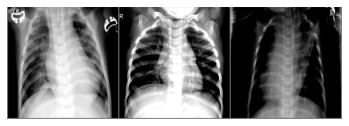

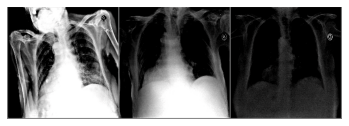

In [142]:
# Use imshow() function to visualize three images from training and three images from testing images 
# and print their ground truth labels 'PNEUMONIA', 'NORMAL'  , 'COVID19'.

imshow(torchvision.utils.make_grid(images[:3].cpu()))
print('Training GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(3)))

# images2=images2.to(device)

imshow(torchvision.utils.make_grid(images2[:3].cpu()))
print('Testing GroundTruth: ', ' '.join('%5s' % classes[labels2[j]] for j in range(3)))




In [143]:
#Define he VGG16 model for transfer learning
model = torchvision.models.vgg16(pretrained=True)
model

C:\PythonEnvs\env7\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\PythonEnvs\env7\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [144]:
#Freezing the Model
for param in model.parameters():
    param.requires_grad = False
for param in model.parameters():
    param.requires_grad = False
#Assume we want to fine-tune (train) the last 3 layers:

model.classifier[1].requires_grad = True
model.classifier[3].requires_grad = True
#For the last layer, because the number of class labels differs compared to ImageNet, 
# we replace the output layer with your own output layer:

model.classifier[6] = torch.nn.Linear(4096, 3)

In [145]:
model = model.to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)

minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_data_loader,
    valid_loader=valid_data_loader,
    test_loader=test_data_loader,
    optimizer=optimizer,
    device=DEVICE,
    scheduler=scheduler,
    scheduler_on='valid_acc',
    logging_interval=100)



Epoch: 001/010 | Batch 0000/0146 | Loss: 0.9907
Epoch: 001/010 | Batch 0100/0146 | Loss: 1.2494
Epoch: 001/010 | Train: 90.06% | Validation: 85.80%
Time elapsed: 1.49 min
Epoch: 002/010 | Batch 0000/0146 | Loss: 1.1433
Epoch: 002/010 | Batch 0100/0146 | Loss: 3.0393
Epoch: 002/010 | Train: 92.25% | Validation: 93.42%
Time elapsed: 2.90 min
Epoch: 003/010 | Batch 0000/0146 | Loss: 0.2443
Epoch: 003/010 | Batch 0100/0146 | Loss: 0.1291
Epoch: 003/010 | Train: 92.79% | Validation: 93.42%
Time elapsed: 4.28 min
Epoch: 004/010 | Batch 0000/0146 | Loss: 1.9326
Epoch: 004/010 | Batch 0100/0146 | Loss: 1.7352
Epoch: 004/010 | Train: 91.95% | Validation: 93.42%
Time elapsed: 5.64 min
Epoch: 005/010 | Batch 0000/0146 | Loss: 1.0897
Epoch: 005/010 | Batch 0100/0146 | Loss: 0.2290
Epoch: 005/010 | Train: 94.33% | Validation: 87.86%
Time elapsed: 7.03 min
Epoch: 006/010 | Batch 0000/0146 | Loss: 0.5541
Epoch: 006/010 | Batch 0100/0146 | Loss: 1.2860
Epoch: 006/010 | Train: 92.27% | Validation: 93.6

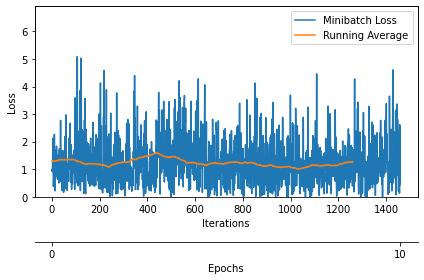

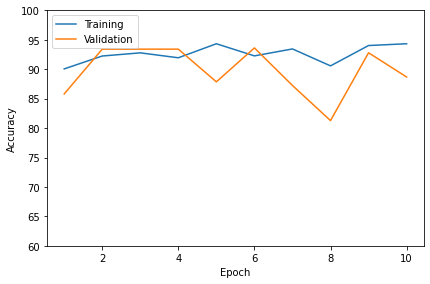

In [146]:
plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_data_loader),
                   results_dir=None,
                   averaging_iterations=200)
plt.show()

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)
plt.ylim([60, 100])
plt.show()

In [147]:
def test_model(model, test_data_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_data_loader:
            images, labels = data
            images, labels = images.to('cuda'), labels.to('cuda')
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Accuracy of the network on the test images: {float(correct)/float(total)*100:.4f}")

test_model(model, test_data_loader)

Accuracy of the network on the test images: 88.2764


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

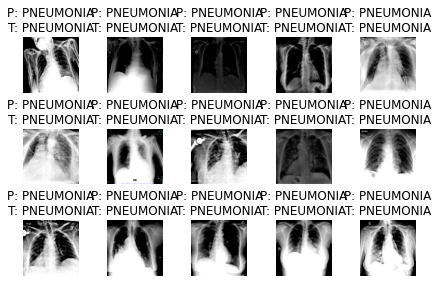

In [148]:
model.cpu()
unnormalizer = UnNormalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
class_dict = {0: 'PNEUMONIA',
              1: 'NORMAL',
              2: 'COVID'}

show_examples(model=model, data_loader=test_data_loader, unnormalizer=unnormalizer, class_dict=class_dict)

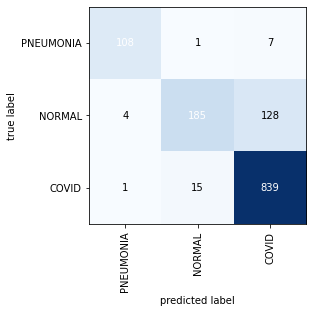

In [149]:
mat = compute_confusion_matrix(model=model, data_loader=test_data_loader, device=torch.device('cpu'))
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show()